# Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

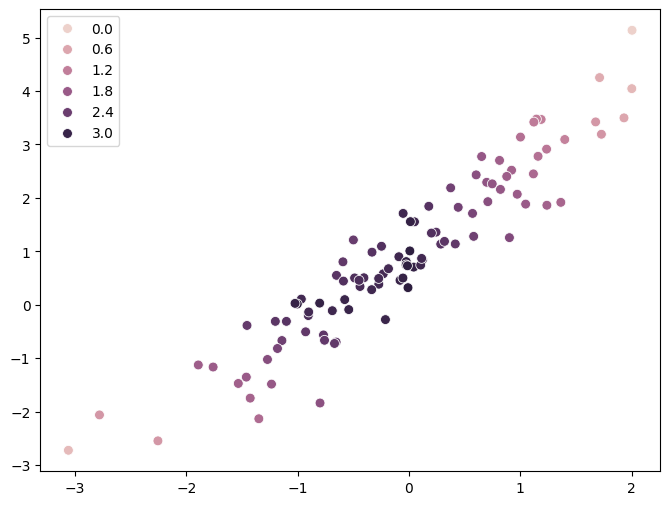

In [4]:
x1 = np.random.normal(size=100)
x2 = x1 * 1.5 + 1 + np.random.normal(size=100, scale=0.5)
X = np.array([x1, x2]).T
y = np.sqrt(np.abs(X.T[0] * X.T[1]))
y = y.max() - y

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X.T[0], y=X.T[1], hue=y, s=50)
plt.show()

# Model

Source:
- <a href="https://www.youtube.com/watch?v=kFwe2ZZU7yw">AssemblyAI</a>

In [5]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTreeRegression:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_var = np.var(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        var_left, var_right = np.var(y[left_idxs]), np.var(y[right_idxs])
        child_variance = (n_left/n) * var_left + (n_right/n) * var_right

        # calculate the IG
        information_gain = parent_var - child_variance
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [8]:
class RandomForestRegression:
    def __init__(self, n_trees=10, max_depth=5, min_samples_split=2, n_features=None) -> None:
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []

        for _ in range(self.n_trees):
            tree = DecisionTreeRegression(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                n_features=self.n_features,
            )
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees]).T
        return np.array([np.mean(pred) for pred in tree_preds])

# Train

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forestReg = RandomForestRegression()
forestReg.fit(X_train, y_train)

# Evaluation

In [10]:
from sklearn.metrics import mean_squared_error

y_pred = forestReg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: {:.2f}\nRMSE: {:.2f}".format(
    mse,
    np.sqrt(mse)
))

MSE: 0.07
RMSE: 0.26
